# Schneider Electric Hackathon - Zero Deforestation Mission

Deforestation is the permanent removal of standing forests, which occurs for a variety of reasons and has many devastating consequences. It is important to stop deforestation, as soon as possible, before the damage is irreversible.

This challenge will consist of using the help of thousands of satellites in space to capture images of the earth's surface in order to detect, as soon as possible, areas in the midst of deforestation and prevent its expansion.

In this Jupyter notebook, a CNN model is applied, which includes:

1. Clone the repository,
2. Load the data,
3. Look for Null values,
4. Preprocess the data,
5. Create the model,
6. Train the model,
7. Validate the model.

## Clone repository

We clone the repository to be able to access the data.

In [1]:
# Public repository
# ! git clone https://github.com/{username}/{repo}.git
! git clone https://github.com/ricdurvin/Schneider_Electric_Hackathon-Deforestation.git

Cloning into 'Schneider_Electric_Hackathon-Deforestation'...
remote: Enumerating objects: 2405, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 2405 (delta 16), reused 37 (delta 8), pack-reused 2356
Receiving objects: 100% (2405/2405), 309.30 MiB | 14.47 MiB/s, done.
Resolving deltas: 100% (16/16), done.


Now, we can see the repository in the Google Collab workspace (left panel) and use its files or data

## Check GPU configuration

We have access via Google Colab to an instance of the GPU. It is important to check the configuration of each Jupyter Notebook to take advantage of the power of the GPU.

How to activate the GPU?

Go to *Runtime/Change runtime type/Hardware* -> GPU

It is not always possible to access GPUs, as we use the free version of Google Colab.

By executing the following command we can see which GPU we are using in this environment.

**Important**: It may happen that different Google Colab environments use different GPU models, so there may be models with different power.

In [2]:
!nvidia-smi

Sat Nov 19 21:57:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install dependencies

Despite having Tensorflow installed on Google Colab by default, we upgraded to the latest stable version.

In [3]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import libraries

It is good practice to import all dependencies at the beginning of Jupyter Notebok (after cloning the repository and installing the dependencies).

In [4]:
import pandas as pd
import tensorflow as tf
from keras import layers
from keras.callbacks import ModelCheckpoint

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report

In [5]:
# Check tensorflow version
tf. __version__

'2.9.2'

In [6]:
%cd /content/Schneider_Electric_Hackathon-Deforestation

/content/Schneider_Electric_Hackathon-Deforestation


## Loading data

We load the data. First we load the information from the csven files into some pandas DataFrames. The paths to the images are in one of the columns of this DataFrames.

In [7]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [8]:
train_df

,label,latitude,longitude,year,example_path
0,0,-2.051853,111.826093,2001,train_test_data/train/1297.png
1,2,-1.989349,105.309496,2013,train_test_data/train/1199.png
2,0,1.223256,100.702217,2014,train_test_data/train/1348.png
3,0,-2.342948,103.890226,2008,train_test_data/train/2214.png
4,0,-0.126555,101.758175,2011,train_test_data/train/2220.png
...,...,...,...,...,...
1709,0,3.819464,117.636112,2016,train_test_data/train/550.png
1710,0,-1.809594,111.531951,2005,train_test_data/train/2264.png
1711,1,0.443397,112.200163,2012,train_test_data/train/1486.png
1712,2,-1.978349,101.970148,2012,train_test_data/train/1170.png


In [9]:
test_df

,latitude,longitude,year,example_path
0,0.761681,122.755954,2006,train_test_data/test/69.png
1,-8.059785,113.053791,2007,train_test_data/test/469.png
2,-2.006610,111.746316,2002,train_test_data/test/6.png
3,0.901765,114.042495,2016,train_test_data/test/351.png
4,1.911210,100.829633,2008,train_test_data/test/1001.png
...,...,...,...,...
630,1.650899,101.314723,2011,train_test_data/test/968.png
631,-1.645649,102.612332,2010,train_test_data/test/54.png
632,-0.557796,114.561609,2016,train_test_data/test/494.png
633,-3.037549,113.872045,2009,train_test_data/test/287.png


### Loading images

We load the images into NumPy arrays

In [10]:
# Path to training images
img_path_train = train_df['example_path']
# Accesing all to training data
x_train = []
# Reading all images
for i in img_path_train:
    img = cv.imread(os.path.join('data',i))
    if img is not None:
        x_train.append(img)
        
# Converting the type from list to NumPy array
x_train = np.array(x_train)

In [11]:
# Accesing all to testing data
# Path to all images
img_path_test = test_df['example_path']
x_test = []
# Reading all images
for i in img_path_test:
    img = cv.imread(os.path.join('data',i))
    if img is not None:
        x_test.append(img)
        
# Converting the type from list to NumPy array
x_test = np.array(x_test)

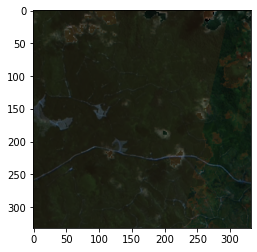

In [12]:
# Accesing to an image
img0 = cv.imread(os.path.join('data',img_path_train[0]))
plt.imshow(img0)

## Looking for Null Values.

It is important to check the existance of NaN values on each of the features DataFrames. 
- By using the method .isnull() we evaluate each object in the DataFrame and provide a boolean value indicating if the data is missing or not.
- By using the method .sum() we determine how many missing values exist in the collection.

In [13]:
train_df.isnull().sum()

label           0
latitude        0
longitude       0
year            0
example_path    0
dtype: int64

In [14]:
test_df.isnull().sum()

latitude        0
longitude       0
year            0
example_path    0
dtype: int64

As we can appreciate, there are no missing values in any of the features DataFrames, therefore we can continue with the next section.

## Preprocessing data

In this section we will explore the different characteristics of the given dataset.

In [15]:
# Shape of the dataset
print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")
# Min and Max Values of the pixels
print(f"Min pixel value: {x_train.min()}; Max pixel value: {x_train.max()}")

x_train shape: (1714, 332, 332, 3)
x_test shape: (635, 332, 332, 3)
Min pixel value: 0; Max pixel value: 255


In [16]:
# Creating labels array
y_train = train_df['label']
n_categories = y_train.nunique()
print(y_train)
print("Number of categories: " + str(n_categories))

0       0
1       2
2       0
3       0
4       0
       ..
1709    0
1710    0
1711    1
1712    2
1713    2
Name: label, Length: 1714, dtype: int64
Number of categories: 3


We split the training set into two subsets, one for model training and one for validation:

In [17]:
# Split the data into train/validation dataset
X_train, X_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.20)

## Check balance data

We check if the training labels are balanced on the problem.

In [18]:
#get unique values and counts of each value
unique, counts = np.unique(y_train, return_counts=True)
print(f"Unique: {unique}")
print(f"Counts: {counts}")

Unique: [0 1 2]
Counts: [675 159 537]


As we can see, the class with value 1 has far fewer samples than the rest of the classes.

To address this problem, we will establish weights for each of the categories, which will be taken into account when training the model.

These weightings shall be made according to the proportion of each of the categories.

In [19]:
# Scaling by total/3 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / counts[0] ) * (counts[0] + counts[1] + counts[2] / 3.0)
weight_for_1 = (1 / counts[1] ) * (counts[0] + counts[1] + counts[2] / 3.0)
weight_for_2 = (1 / counts[2] ) * (counts[0] + counts[1] + counts[2] / 3.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))

Weight for class 0: 1.50
Weight for class 1: 6.37
Weight for class 2: 1.89


The categories are converted into binary variables to facilitate the training of the model.

In [20]:
# One-hot encode the labels
y_train_OHE = tf.keras.utils.to_categorical(y_train, n_categories)
y_valid_OHE = tf.keras.utils.to_categorical(y_valid, n_categories)

In [21]:
print("x_train shape: ", X_train.shape)
print("x_valid shape: ", X_valid.shape)
print("x_test shape: ", x_test.shape)
print("y_train_OHE shape: ", y_train_OHE.shape)
print("y_valid_OHE shape: ", y_valid_OHE.shape)

x_train shape:  (1371, 332, 332, 3)
x_valid shape:  (343, 332, 332, 3)
x_test shape:  (635, 332, 332, 3)
y_train_OHE shape:  (1371, 3)
y_valid_OHE shape:  (343, 3)


## Resize, rescale and data augmentation

One of the things we can do to help training the model is to rescale the images, thus decreasing the size, normalise the pixel values between 0 and 1 and do a little pre-processing to increase the training set.

In [22]:
IMG_SIZE = 300

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

In [23]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2)
])

## Create model

Let's try a CNN (Convolutional Neural Network).

In [24]:
model = tf.keras.Sequential()

model.add(resize_and_rescale)
model.add(data_augmentation)

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))

# model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
# model.add(tf.keras.layers.Dropout(0.3))

# model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
# model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(n_categories, activation='softmax'))

In [25]:
model.build((None, 332, 332, 3)) # `input_shape` is the shape of the input data

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 300, 300, 64)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 150, 150, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      8224      
                                                      

## Compile the model
Configure the learning process with compile() API before training the model. It receives three arguments:

*   An optimizer 
*   A loss function 
*   A list of metrics 

In [26]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['categorical_accuracy'])

## Training model

We are now ready to train the model. Callbacks will be used to monitor the training of the model:


*   EarlyStopping: to stop the model when no improvement in training is found
*   ModelCheckpoint: to save the best model



In [27]:
model_earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [28]:
checkpoint_filepath = '/tmp/checkpoint'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    verbose = 1,
    monitor='val_categorical_accuracy',
    save_best_only=True)

# checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose = 1, save_best_only=True)

In [29]:
# Parameters
batch_size=64
epochs=500

In [30]:
history = model.fit(X_train,
         y_train_OHE,
         batch_size=batch_size,
         epochs=epochs,
         validation_data=(X_valid, y_valid_OHE),
         callbacks=[model_checkpoint_callback, model_earlystopping_callback],
         class_weight=class_weight)

Epoch 1/500
22/22 [==============================] - ETA: 0s - loss: 5.8446 - categorical_accuracy: 0.2815
Epoch 1: val_categorical_accuracy improved from -inf to 0.11370, saving model to /tmp/checkpoint
22/22 [==============================] - 19s 402ms/step - loss: 5.8446 - categorical_accuracy: 0.2815 - val_loss: 1.0997 - val_categorical_accuracy: 0.1137
Epoch 2/500
22/22 [==============================] - ETA: 0s - loss: 2.4365 - categorical_accuracy: 0.3793
Epoch 2: val_categorical_accuracy did not improve from 0.11370
22/22 [==============================] - 7s 300ms/step - loss: 2.4365 - categorical_accuracy: 0.3793 - val_loss: 1.0992 - val_categorical_accuracy: 0.1079
Epoch 3/500
22/22 [==============================] - ETA: 0s - loss: 2.4350 - categorical_accuracy: 0.4624
Epoch 3: val_categorical_accuracy did not improve from 0.11370
22/22 [==============================] - 7s 298ms/step - loss: 2.4350 - categorical_accuracy: 0.4624 - val_loss: 1.0999 - val_categorical_accurac

In [31]:
# Load the weights with the best validation accuracy
model.load_weights('/tmp/checkpoint')

We plot the graphs to obtain the training information.

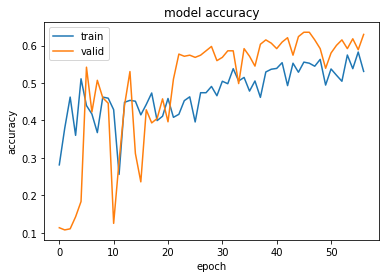

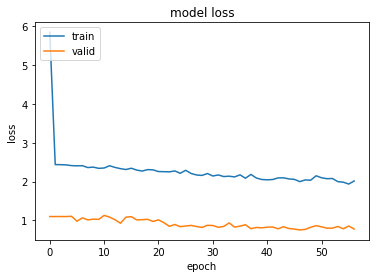

In [32]:
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

## Evaluation of the model

We evaluate the performance of the model

In [33]:
y_pred1 = model.predict(X_valid)
y_pred = np.argmax(y_pred1, axis=1)

11/11 [==============================] - 1s 38ms/step


In [34]:
# Print f1, precision, and recall scores
print(f"Precision score: {precision_score(y_valid, y_pred , average='macro')}")
print(f"Recall score: {recall_score(y_valid, y_pred , average='macro')}")
print(f"F1 score: {f1_score(y_valid, y_pred , average='macro')}")

Precision score: 0.5496923255543945
Recall score: 0.5711264983992257
F1 score: 0.5491332896410539


In [35]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.81      0.78       185
           1       0.31      0.49      0.38        37
           2       0.59      0.42      0.49       121

    accuracy                           0.64       343
   macro avg       0.55      0.57      0.55       343
weighted avg       0.65      0.64      0.63       343



## Predictions

Finally, we perform the model predictions.

In [36]:
predictions_prob = model.predict(x_test)

20/20 [==============================] - 1s 40ms/step


In [37]:
predictions = np.argmax(predictions_prob, axis=1)

We save the results in a json file

In [38]:
pred_df = pd.DataFrame(predictions, columns = ['target'])

In [39]:
pred_df.to_json(r'predict.json', indent=4)


In [40]:
pred_df

,target
0,0
1,2
2,0
3,2
4,1
...,...
630,1
631,1
632,1
633,0
